In [2]:
from tqdm import tqdm
from datetime import datetime

import pandas as pd
import numpy as np
import scipy.io as sio

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from utils.loss import efficiency_cost, QoS_cost, revenue_cost
from utils.parameters import system_parameters
from utils.policy_prior import opt_QoS, opt_QoS_seq

## Data Loading ##

In [3]:
demand_org = sio.loadmat('data/demand.mat')['test']
renewables = sio.loadmat('data/renewables.mat')['test']
print('(No. sequence , episode length)', demand_org.shape, renewables.shape)

transit_noise_a = sio.loadmat('data/transit_noise_1.mat')['test']
transit_noise_x = sio.loadmat('data/transit_noise_2.mat')['test']

transit_noise_a.shape, transit_noise_x.shape

(No. sequence , episode length) (1416, 24) (1416, 24)


((1416, 24), (1416, 24))

In [4]:
# build a testing dataloader
H = system_parameters.H
context_test = np.concatenate([np.reshape(demand_org,[-1,1,H]),np.reshape(renewables,[-1,1,H]),
                               np.reshape(transit_noise_a,[-1,1,H]),np.reshape(transit_noise_x,[-1,1,H])],axis=1)
test_dataloader = DataLoader(context_test, batch_size=1, shuffle=False, num_workers=1)

## System Model ##
Transition model is $x_h=f(x_{h-1},\mu_h,a_h)=[x_{h-1}(1-transitnoisex)+\mu_h-(powerconvert+transitnoisea)\cdot a_h]^+$

In [5]:
H = system_parameters.H # episode length

power_convert = system_parameters.power_convert # average workload processed when unit power is consumed
D1 = system_parameters.D1 
D2 = system_parameters.D2
D3 = system_parameters.D3 # D1, D2, D3 are Q1, Q2, Q3 in the paper.
C1 = system_parameters.C1
C2 = system_parameters.C2 # C1, C2 are gamma_1 and gamma_2 in the paper.
gamma = system_parameters.gamma

Lambda = system_parameters.Lambda 
Budget= system_parameters.Budget

size_X = system_parameters.size_X # maximum value of state
size_D = system_parameters.size_D # maximum value of demand

V_d = system_parameters.V_d
alpha = system_parameters.alpha


## Our Alg (ACRL) ##

### Calculate $\Gamma$ in Proposition 4.1. ###
For the considered dynamic function, we have $\frac{\partial f(x_{h-1},a_h)}{x_{h-1}}\leq |\frac{transitnoise}{powerconvert}|\leq 1/4$, so perturbation function is $p(h_2-h_1)=(1/4)^{h_2-h_1}$.

The Lipschitz constant of cost function is $L_{c,x}=\max \frac{\partial c(x_{h-1},a_h)}{\partial x_{h-1}}\leq \frac{D_1}{8}|sizeX+sizeD|+1/4D_2$ and $L_{c,a}=\max \frac{\partial c(x_{h-1},a_h)}{\partial a_h}\leq 2D_1\cdot sizeX+D_2$.

The Lipschitz constant of dynamic function us $L_f=$\frac{\partial f(x_{h-1},a_h)}{a_h}\leq |powerconvert+transitnoise|\leq 1$.


In [6]:
seq_len = context_test.shape[2]
# q_mat stores the impact of action difference at j on the cost at i
q_mat = np.zeros([seq_len,seq_len])
for j in range(seq_len):
    for i in range(j, seq_len):
        if i == j:
            q_mat[j][i] = 2*D1*size_X+D2           
        else:
            q_mat[j][i] = (D1/8*(size_X+size_D)+D2/4) * (0.25**(i-1-j))
            
# Gamma_list is the sum effect of action difference at j on the following steps j<i<=H
Gamma_list = np.sum(q_mat, 1)

# Gamma_mat is the sum effect of action difference at j on the steps h<=i<=H, for some h>j.
Gamma_mat = np.zeros([seq_len,seq_len])
for j in range(seq_len):
    for t in range(j, seq_len):
        Gamma_mat[j][t] = np.sum(q_mat[j,t:seq_len])

q_mat = torch.tensor(q_mat)
Gamma_list = torch.tensor(Gamma_list)
Gamma_mat = torch.tensor(Gamma_mat)

### Build the ACD policy in Algorithm 1 ###

In [7]:
class Net(torch.nn.Module):
    def __init__(self,D_in,D_out,k1,k2):
        super(Net, self).__init__()
        self.input_linear = nn.Linear(D_in, k1)
        self.hidden_linear = nn.Linear(k1, k2)
        self.output_linear = nn.Linear(k2, D_out)
        torch.nn.init.kaiming_normal_(self.input_linear.weight,nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.hidden_linear.weight,nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.output_linear.weight,nonlinearity='relu')
        

    def base_forward(self, base_in_c,base_in_b, base_in_s):
        base_in=torch.cat([base_in_c, base_in_b, base_in_s], -1)
        h1_relu = F.relu(self.input_linear(base_in))
        h2_relu = F.relu(self.hidden_linear(h1_relu))
        y_pred = F.relu(self.output_linear(h2_relu))
        return y_pred
    
    def policy_forward(self, policy_in_c, trans_noise, demand_noise, action_pre, state_pre):
        # inputs: policy_in_c: demand and renewable; trans_noise, demand_noise: randomness in transition functions; 
        # action_pre:last action; state_pre: last state
        # outputs: actions in an episode
        action_ = action_pre
        state_ = state_pre
        action_out_list = []
        seq_len = policy_in_c.size(1)
        # Initialize the allowed deviation D_0 in Corollary 4.2
        bgt = (Lambda * D3  + Budget/seq_len) * torch.ones([policy_in_c.size(0), 1])
        cum_c = torch.zeros([policy_in_c.size(0),1])
        dev = []
        for t in range(seq_len):
            Gamma = Gamma_list[t]
            policy_t_c = policy_in_c[:,t]
            noise_t = trans_noise[:,t]
            noise2_t = demand_noise[:,t]
            # get the ML action
            action_ml = self.base_forward(policy_t_c,action_,state_)
            # get the prior action by opt_QoS
            action_prior = opt_QoS(state_, policy_t_c[:,0].unsqueeze(1), power_convert)
            # project the ML action into the safe action set
            action_out = action_ml + F.relu(torch.abs(action_ml-action_prior) - bgt/Gamma) * ((action_ml<action_prior)*2-1.0)   
            action_out_list.append(action_out)
            
            action_ = action_out
            # update the state based on transition model
            state_ = torch.minimum(F.relu(state_ * (1-noise2_t) + policy_t_c[:,0].unsqueeze(1) - (0.8+noise_t)*action_out),
                                  torch.tensor(15))
            
            # Update the allowed deviation Dh in Corollary 4.2
            if t < seq_len-1:
                c_t = D1 * state_**2 + D2 * state_ +D3 # true cost
                action_diff = torch.abs(action_out-action_prior) # action difference
                dev.append(action_diff)
                devtensor = torch.stack(dev, dim =2)
                cum_d = torch.matmul(devtensor, q_mat[:t+1,t].unsqueeze(1))[:,:,0] 
                c_t_prior = torch.maximum(torch.ones([policy_in_c.size(0),1])*D3, c_t - cum_d)# $\hat{c}_i^{\dagger}$ in Proposition 4.1
                cum_c += (1+Lambda)*c_t_prior - c_t # $(1+\lambda)\hat{c}_i^{\dagger}-c_i$
                cum_d_g = torch.matmul(devtensor, Gamma_mat[:t+1,t+1].unsqueeze(1))[:,:,0] # $\Gamma_{i,j}\cdot d_i$

                bgt = torch.maximum(F.relu(bgt + Lambda * D3 + Budget/seq_len - action_diff * Gamma),
                                   cum_c - cum_d_g + Lambda * D3  + Budget/seq_len*(t+2))  # Update the allowed deviation by (6)             
            else:
                bgt = F.relu(bgt + Lambda * D3 + Budget/seq_len - action_diff * Gamma)
                       
        action_out=torch.cat(action_out_list,-1)
        return action_out

### Evaluation ###

In [8]:
# define a testing function to calculate efficiency cost, revenue cost, and QoS loss
def testing (net):     
    efficiency_loss_list = []
    rev_loss_list = []
    qos_loss_list = []
    loss_list = []
    remaining_demand_list = []

    for _, context in enumerate(test_dataloader):
        # time_input=torch.tensor(np.tile(np.arange(N)/N,(batch_size,1)).reshape(batch_size,N,1))
        seq_len = context.size(2)
        policy_in_c = torch.transpose(context[:,:2], 1,2)
        trans_noise = context[:,2].view(-1, seq_len, 1)
        demand_noise = context[:,3].view(-1, seq_len, 1)
        action_pre = torch.zeros([policy_in_c.size(0),1])
        state_pre = torch.zeros([policy_in_c.size(0),1])
        action_out=net.policy_forward(policy_in_c,trans_noise,demand_noise,action_pre,state_pre)
        #         print(action_out,obj_out,bgt_out)
        action_out = action_out.unsqueeze(2)
        # print(action_out)
        efficiency_loss = efficiency_cost(policy_in_c[:,:,1].unsqueeze(2),action_out, C1, C2)
        QoS_loss, remaining_demand = QoS_cost(policy_in_c[:,:,0].unsqueeze(2),trans_noise,demand_noise,action_out, D1,D2,D3)
        rev_loss = revenue_cost (trans_noise, action_out ,V_d, alpha)
        loss = efficiency_loss + rev_loss * gamma

        efficiency_loss_list.append(efficiency_loss.detach().numpy())
        qos_loss_list.append(QoS_loss.detach().numpy())
        rev_loss_list.append(rev_loss.detach().numpy())
        loss_list.append(loss.detach().numpy())
        remaining_demand_list.append(remaining_demand.detach().numpy())

    efficiency_loss_list = np.array(efficiency_loss_list)
    qos_loss_list = np.array(qos_loss_list)
    loss_list = np.array(loss_list)
    return loss_list, efficiency_loss_list, qos_loss_list

In [9]:
# Testing of RL+ACD for b=2 and lamdba=[0,2,4,6,8,10]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

global_hiddens = [40,40] # No of hidden neurons
PATH = './runs_05_22/rnn_15:41:02' # Path of neural model 

Budget = 24*2
RLACD_mean_reward_b2 = []
RLACD_max_cost_b2 = []
for Lambda in range(0,11,2):
    net=Net(4,1,global_hiddens[0],global_hiddens[1]).double().to(device)
    net.load_state_dict(torch.load(PATH))

    loss_list, efficiency_loss_list, QoS_loss_list=testing (net)
    print('mean','Lambda', Lambda, 'reward:',-np.mean(loss_list), 'QoS loss:', np.mean(QoS_loss_list))
    print('worst','Lambda', Lambda, 'reward:',-np.max(loss_list), 'QoS loss:', np.max(QoS_loss_list))
    RLACD_mean_reward_b2.append([-np.mean(loss_list),np.var(loss_list)])
    RLACD_max_cost_b2.append([np.max(QoS_loss_list),np.mean(QoS_loss_list)])

Using cpu device
mean Lambda 0 reward: 510.33063116928975 QoS loss: 35.80446421313237
worst Lambda 0 reward: 367.4144059339813 QoS loss: 47.45992797519986
mean Lambda 2 reward: 516.9836314880374 QoS loss: 50.610065489282455
worst Lambda 2 reward: 375.9622262930572 QoS loss: 69.3467582201749
mean Lambda 4 reward: 521.076205444876 QoS loss: 68.99857753324062
worst Lambda 4 reward: 381.7261653266158 QoS loss: 95.28585928728224
mean Lambda 6 reward: 524.1734103901772 QoS loss: 89.83940872781633
worst Lambda 6 reward: 387.4637914524676 QoS loss: 124.11813014969866
mean Lambda 8 reward: 526.7514071228277 QoS loss: 112.5068632806447
worst Lambda 8 reward: 391.7426444701097 QoS loss: 155.2190510094464
mean Lambda 10 reward: 528.9033845528272 QoS loss: 136.58790272155525
worst Lambda 10 reward: 394.67847822072355 QoS loss: 188.12005475193868


In [10]:
# Testing of ACRL for b=2 and lamdba=[0,2,4,6,8,10]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

global_hiddens = [40,40] # No of hidden neurons

Budget = 24*2
ACRL_mean_reward_b2 = []
ACRL_max_cost_b2 = []
for Lambda in range(0,11,2):
    net=Net(4,1,global_hiddens[0],global_hiddens[1]).double().to(device)
    PATH = './runs_05_22/ACRL_'+str(Lambda)+'B'+str(Budget)
    net.load_state_dict(torch.load(PATH))
    loss_list, efficiency_loss_list, QoS_loss_list=testing (net)
    print('mean','Lambda', Lambda, 'reward:',-np.mean(loss_list), 'QoS loss:', np.mean(QoS_loss_list))
    print('worst','Lambda', Lambda, 'reward:',-np.max(loss_list), 'QoS loss:', np.max(QoS_loss_list))
    ACRL_mean_reward_b2.append([-np.mean(loss_list),np.var(loss_list)])
    ACRL_max_cost_b2.append([np.max(QoS_loss_list),np.mean(QoS_loss_list)])

Using cpu device
mean Lambda 0 reward: 511.01971449488406 QoS loss: 34.15128742153946
worst Lambda 0 reward: 368.6166848088509 QoS loss: 46.19476092051647
mean Lambda 2 reward: 518.5092081159039 QoS loss: 46.05393448171973
worst Lambda 2 reward: 379.2569197533838 QoS loss: 67.85117648119554
mean Lambda 4 reward: 523.086886848908 QoS loss: 59.63618913809124
worst Lambda 4 reward: 384.72871883169597 QoS loss: 93.44646544991237
mean Lambda 6 reward: 526.4853606064218 QoS loss: 75.91063057670706
worst Lambda 6 reward: 390.69374078937807 QoS loss: 122.01292402263114
mean Lambda 8 reward: 528.6230279393573 QoS loss: 83.11448313729618
worst Lambda 8 reward: 399.9772531788035 QoS loss: 150.4241549928771
mean Lambda 10 reward: 531.036479614227 QoS loss: 98.73202841182415
worst Lambda 10 reward: 405.24668751192706 QoS loss: 184.5672013652405


In [11]:
# Testing of RL+ACD for b=6 and lamdba=[0,2,4,6,8,10]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

global_hiddens = [40,40] # No of hidden neurons
PATH = './runs_05_22/rnn_15:41:02' # Path of neural model 

Budget = 24*6
RLACD_mean_reward_b6 = []
RLACD_max_cost_b6 = []
for Lambda in range(0,11,2):
    net=Net(4,1,global_hiddens[0],global_hiddens[1]).double().to(device)
    net.load_state_dict(torch.load(PATH))

    loss_list, efficiency_loss_list, QoS_loss_list=testing (net)
    print('mean','Lambda', Lambda, 'reward:',-np.mean(loss_list), 'QoS loss:', np.mean(QoS_loss_list))
    print('worst','Lambda', Lambda, 'reward:',-np.max(loss_list), 'QoS loss:', np.max(QoS_loss_list))
    RLACD_mean_reward_b6.append([-np.mean(loss_list),np.var(loss_list)])
    RLACD_max_cost_b6.append([np.max(QoS_loss_list),np.mean(QoS_loss_list)])

Using cpu device
mean Lambda 0 reward: 521.0759348068426 QoS loss: 68.98934637919326
worst Lambda 0 reward: 381.7261650317713 QoS loss: 95.28586333074702
mean Lambda 2 reward: 524.1731588899353 QoS loss: 89.83136453356691
worst Lambda 2 reward: 387.4637915215744 QoS loss: 124.11812925164638
mean Lambda 4 reward: 526.7514117466295 QoS loss: 112.49870517529973
worst Lambda 4 reward: 391.74264377681226 QoS loss: 155.21904647173795
mean Lambda 6 reward: 528.9036182128934 QoS loss: 136.57871695646875
worst Lambda 6 reward: 394.678478019455 QoS loss: 188.12006733318105
mean Lambda 8 reward: 530.7902104354504 QoS loss: 161.58638681418287
worst Lambda 8 reward: 396.3559584650582 QoS loss: 222.44330541401837
mean Lambda 10 reward: 532.4711401989883 QoS loss: 187.23435209471995
worst Lambda 10 reward: 398.86032693838 QoS loss: 257.96722929653976


In [12]:
# Testing of ACRL for b=6 and lamdba=[0,2,4,6,8,10]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

global_hiddens = [40,40] # No of hidden neurons

Budget = 24*6
ACRL_mean_reward_b6 = []
ACRL_max_cost_b6 = []
for Lambda in range(0,11,2):
    net=Net(4,1,global_hiddens[0],global_hiddens[1]).double().to(device)
    PATH = './runs_05_22/ACRL_'+str(Lambda)+'B'+str(Budget)
    net.load_state_dict(torch.load(PATH))
    loss_list, efficiency_loss_list, QoS_loss_list=testing (net)
    print('mean','Lambda', Lambda, 'reward:',-np.mean(loss_list), 'QoS loss:', np.mean(QoS_loss_list))
    print('worst','Lambda', Lambda, 'reward:',-np.max(loss_list), 'QoS loss:', np.max(QoS_loss_list))
    ACRL_mean_reward_b6.append([-np.mean(loss_list),np.var(loss_list)])
    ACRL_max_cost_b6.append([np.max(QoS_loss_list),np.mean(QoS_loss_list)])

Using cpu device
mean Lambda 0 reward: 523.0793336128481 QoS loss: 59.50678939878494
worst Lambda 0 reward: 384.7473692463524 QoS loss: 93.2940695685061
mean Lambda 2 reward: 526.345832213633 QoS loss: 73.43035618853703
worst Lambda 2 reward: 391.5407977518998 QoS loss: 121.75185463502683
mean Lambda 4 reward: 528.963134169719 QoS loss: 87.43630500572154
worst Lambda 4 reward: 398.89891531265266 QoS loss: 152.35002707208102
mean Lambda 6 reward: 531.1562653895878 QoS loss: 100.76225550455808
worst Lambda 6 reward: 404.82714279343276 QoS loss: 184.1715932300452
mean Lambda 8 reward: 533.4247604662656 QoS loss: 121.46814123151466
worst Lambda 8 reward: 408.6929329780536 QoS loss: 217.96716987870565
mean Lambda 10 reward: 535.5470256699742 QoS loss: 148.42324394960983
worst Lambda 10 reward: 412.2415160389514 QoS loss: 254.57557620424117


## Regret w.r.t. $\lambda$ and $b$ ##

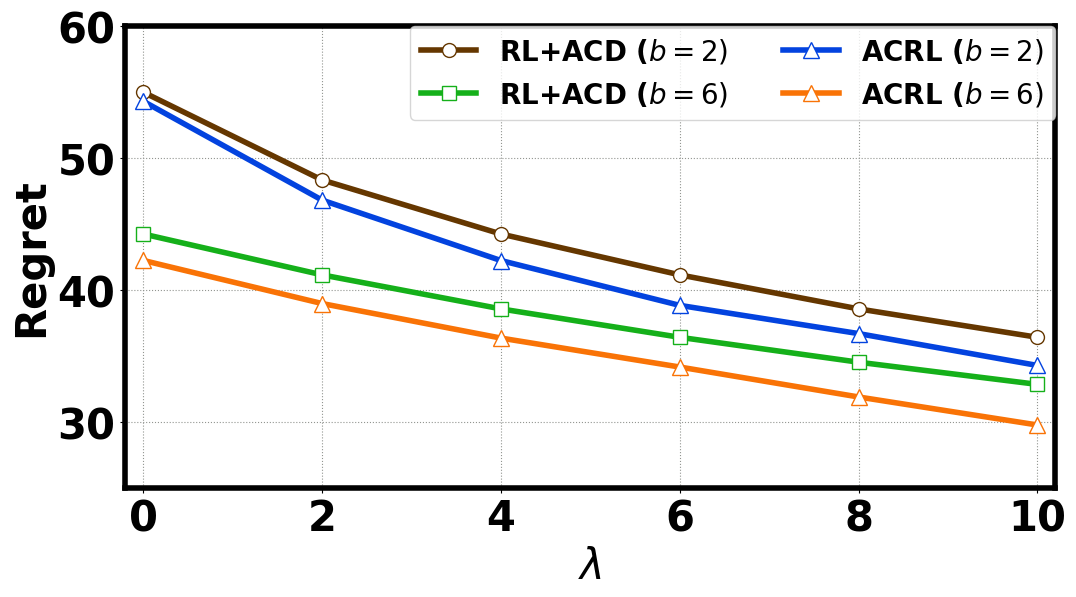

In [13]:
RLACD_regret_b2 = 565.3 - np.array(RLACD_mean_reward_b2)[:,0]
RLACD_regret_b6 = 565.3 - np.array(RLACD_mean_reward_b6)[:,0]
ACRL_regret_b2 = 565.3 - np.array(ACRL_mean_reward_b2)[:,0]
ACRL_regret_b6 = 565.3 - np.array(ACRL_mean_reward_b6)[:,0]

fig1=plt.figure(1,figsize=[12,6])
plt.ylabel('Regret',fontsize=30,fontweight='bold')
plt.xlabel(r'$\lambda$',fontsize=30,fontweight='bold')


plt.plot(RLACD_regret_b2,linewidth=4.0,color='xkcd:brown', marker='o',mfc='w',markersize=10, label='RL+ACD ($b=2)$')

plt.plot(RLACD_regret_b6,linewidth=4.0,color='xkcd:green', marker='s',mfc='w',markersize=10, label='RL+ACD ($b=6)$')

plt.plot(ACRL_regret_b2,linewidth=4.0,color='xkcd:blue', marker='^',mfc='w',markersize=12, label='ACRL ($b=2)$')

plt.plot(ACRL_regret_b6,linewidth=4.0,color='xkcd:orange', marker='^',mfc='w',markersize=12, label='ACRL ($b=6)$')


plt.axis([-0.1, 5.1, 25, 60])
plt.xticks([0,1,2,3,4,5],[0,2,4,6,8,10],fontsize = 30,fontweight='bold')
plt.yticks([30,40,50,60],fontsize = 30,fontweight='bold')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', prop={'size': 20,'weight':'bold'},ncol=2,borderaxespad=0.)
plt.grid(color='xkcd:gray', linestyle=':')
ax=plt.gca();
ax.spines['bottom'].set_linewidth(4);
ax.spines['left'].set_linewidth(4);
ax.spines['right'].set_linewidth(4);
ax.spines['top'].set_linewidth(4);